<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/NLP/Text_classification/news_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification

In [ ]:
%%capture
!pip install datasets

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Data preparation

In [ ]:
dataset = datasets.load_dataset('ag_news')

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
words = Counter()
for example in tqdm(dataset['train']['text']):
  processed_text = example.lower().translate(str.maketrans('', '', string.punctuation))
  for word in word_tokenize(processed_text):
    words[word] += 1

  0%|          | 0/120000 [00:00<?, ?it/s]

In [ ]:
tags = ['<unk>', '<bos>',' <eos>', '<pad>']
vocab = set(tags)
counter_threshold = 25

In [ ]:
for char, count in words.items():
  if count > counter_threshold:
    vocab.add(char)

In [ ]:
word2idx = {char:i for i, char in enumerate(vocab)}
idx2word = {i:char for char, i in word2idx.items()}

### WordDataset class

In [ ]:
class WordDataset:
  def __init__(self, sent):
    self.data = sent
    self.unk_id, self.bos_id, self.eos_id, self.pad_id  = [word2idx[tag] for tag in tags]




  def ___getitem__(self, idx: int) -> list:
    processed_txt = self.data[idx]['text'].lower().translate(str.maketrans('', '', string.punctuation))
    tok_sent = [self.bos_id]
    tok_sent += [word2idx.get(word, self.unk_id) for word in word_tokenize(processed_txt)]
    tok_sent += [self.eos_id]

    train_sample = {
        'text': tok_sent,
        'label': self.data[idx]['label']
    }
    return train_sample
  def __getitem__(self, idx: int) -> dict:
    processed_txt = self.data[idx]['text'].lower().translate(str.maketrans('', '', string.punctuation))
    tok_sent = [self.bos_id]
    tok_sent += [word2idx.get(word, self.unk_id) for word in word_tokenize(processed_txt)]
    tok_sent += [self.eos_id]

    train_sample = {
        'text': tok_sent,
        'label': self.data[idx]['label']
    }
    return train_sample


  def __len__(self) -> int:
    return len(self.data)


def collate_fn_with_padding(input_batch: List[List[int]], pad_id=word2idx["<pad>"], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for seq in input_batch:
        seq['text'] = seq['text'][:max_seq_len]
        for _ in range(max_seq_len - len(seq['text'])):
            seq['text'].append(pad_id)

        new_batch.append(seq['text'])

    seqs = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)
    return {'input_idx': seqs, 'label': labels}



def collate_fn_with_padding_2(input_batch, pad_id, max_len):
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)
    new_batch = []
    labels = []
    for item in input_batch:
        p_seq = item['text'][:max_seq_len] + [pad_id] * (max_seq_len - len(item['text']))
        new_batch.append(p_seq)
        labels.append(item['label'])
    seqs = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor(labels).to(device)
    return {'input_idx': seqs, 'label': labels}


### Split and load data

In [ ]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Task

Get highest score with evaluate func

In [ ]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_idx'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Experiment

### Baseline

In [ ]:
class RNNModel(nn.Module):
  def __init__(self, vocab_size: int, hidden_dim: int = 512, num_classes: int = 4, bi = False, rnn_layers = 2):
    super(RNNModel, self).__init__()
    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_dim)
    self.drop = nn.Dropout(0.2)
    self.rnn = nn.RNN(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=rnn_layers, batch_first=True, bidirectional=bi)
    self.fc_1 = nn.Linear(in_features=hidden_dim*(bi+1), out_features=hidden_dim//2)
    self.fc_2 = nn.Linear(in_features=hidden_dim//2, out_features=num_classes)

  def forward(self, x):
    embeddings = self.embedding(x)
    x, last_cell = self.rnn(embeddings)
    x = F.tanh(x.max(dim=1)[0])
    x = self.fc_1(x)
    x = F.relu(x)
    x = self.drop(x)
    x = self.fc_2(x)
    return x

In [ ]:
class CFG:
  epochs=6

def get_score(value, loader):
  return value / len(loader)

def round_score(ilist, idx, n=3):
  return round(ilist[idx], n)

In [ ]:
def plot_loss_and_acc(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss', color='red')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='red')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Train baseline and calc score (1 point)

In [ ]:
def epoch_train(model, loader, optimizer, criterion, name, n):
  avg_loss = 0
  avg_acc = 0
  for batch in tqdm(loader, desc=f"Epoch {name}: {n}"):
      X, y = batch["input_idx"], batch["label"]
      y_hat = model(X)
      loss = criterion(y_hat, y)

      if name == 'Train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      avg_loss += loss.item()
      probs = torch.softmax(y_hat, dim=1)
      y_pred = torch.argmax(probs, dim=1)
      avg_acc += (y_pred == y).sum().item() / len(y)
  loss_score = get_score(avg_loss, loader)
  acc_score =  get_score(avg_acc, loader)
  print(f'loss: {round(loss_score, 4)}\nacc: {round(acc_score*100, 2)}')
  return loss_score, acc_score

In [ ]:
def fit(model, optimizer, criterion, scheduler, trainloader, valloader):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    best_model = None
    best_val_acc = 0.0

    for epoch in tqdm(range(CFG.epochs)):

        model.train()
        train_avg_loss, train_avg_acc = epoch_train(model, trainloader, optimizer, criterion, 'Train', epoch+1)
        scheduler.step()

        train_loss.append(train_avg_loss)
        train_acc.append(train_avg_acc)

        model.eval()
        with torch.no_grad():
          val_avg_loss, val_avg_acc = epoch_train(model, valloader, optimizer, criterion, 'Val', epoch+1)

        val_loss.append(val_avg_loss)
        val_acc.append(val_avg_acc)

        if val_avg_acc > best_val_acc:  # Check if current validation accuracy is better than the best so far
            best_val_acc = val_avg_acc
            best_model = model.state_dict()


        best_idx = val_acc.index(max(val_acc))
        print(f"Epoch: {epoch+1}/{CFG.epochs}:\n\tTrain: \
                                 \n\t\ttrain_loss = {round_score(train_loss, best_idx, 5)} \
                                 \n\t\ttrain acc = {round_score(train_acc, best_idx)}% \
                                 \n\tVal: \
                                 \n\t\tval loss = {round_score(val_loss, best_idx, 5)} \
                                  \n\t\tval acc = {round_score(val_acc, best_idx)}%")

    return  best_model, (train_loss, val_loss, train_acc, val_acc)

In [ ]:
OUTPUT_DIM = len(set(dataset['train']['label'])) # Number of classes
PAD_IDX = word2idx['<pad>']

In [ ]:
def test_model(model_class, train_dataloder=train_dataloader, eval_dataloader=eval_dataloader, hd=512, lr=4e-4, rnn_layers=2, bi=False):

  model = model_class(vocab_size=len(vocab), hidden_dim=hd, num_classes=4, rnn_layers=rnn_layers, bi=bi).to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss().to(device)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5], gamma=0.5)
  best_model, history = fit(model, optimizer, criterion, scheduler, train_dataloader, eval_dataloader)
  plot_loss_and_acc(*history)
  model.load_state_dict(best_model)
  return model

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch Train: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.4326
acc: 84.1


Epoch Val: 1:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3146
acc: 89.43
Epoch: 1/3:
	Train:                                  
		train_loss = 0.43263                                  
		train acc = 0.841%                                  
	Val:                                  
		val loss = 0.31462                                   
		val acc = 0.894%


Epoch Train: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2671
acc: 90.92


Epoch Val: 2:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2918
acc: 90.01
Epoch: 2/3:
	Train:                                  
		train_loss = 0.26709                                  
		train acc = 0.909%                                  
	Val:                                  
		val loss = 0.2918                                   
		val acc = 0.9%


Epoch Train: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.224
acc: 92.35


Epoch Val: 3:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2755
acc: 91.2
Epoch: 3/3:
	Train:                                  
		train_loss = 0.22396                                  
		train acc = 0.923%                                  
	Val:                                  
		val loss = 0.27551                                   
		val acc = 0.912%


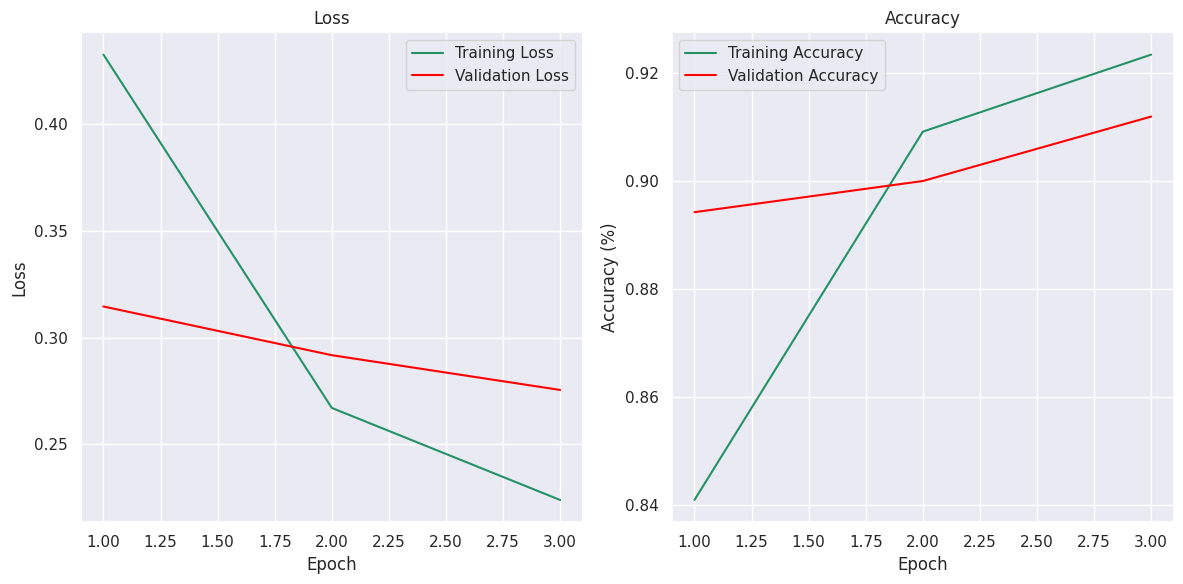

In [ ]:
CFG.epochs = 3
best_model = test_model(RNNModel)

In [ ]:
dummy_model = RNNModel(vocab_size=len(vocab), hidden_dim=512, num_classes=4).to(device)
dummy_model.load_state_dict(best_model)
evaluate(dummy_model, eval_dataloader)

0.9091999530792236

Had to stop it here since there won't be any space to improve :)
However this is a result for a simple RNN, not bidirectional, max aggregation, 2 rnn layers and 2 fc layers with 0.2 dropout, tanh for rnn and relu for fc, 4e-4 lr and default weight decay

### Improving model experiment (4 points /2 each)

one change per experiment

#### Try GRU or LSTM

In [ ]:
class LSTMModel(nn.Module):
  def __init__(self, vocab_size: int, hidden_dim: int = 512, num_classes: int = 4, bi = True, rnn_layers = 2):
    super(LSTMModel, self).__init__()
    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_dim)
    self.drop = nn.Dropout(0.2)
    self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=rnn_layers, batch_first=True, bidirectional=bi)
    self.fc_1 = nn.Linear(in_features=hidden_dim*2, out_features=hidden_dim//2)
    self.fc_2 = nn.Linear(in_features=hidden_dim//2, out_features=num_classes)


  def forward(self, x):
    embeddings = self.embedding(x)
    x, last_cell = self.lstm(embeddings)
    x = F.tanh(x.mean(dim=1))
    x = self.fc_1(x)
    x = F.relu(x)
    x = self.drop(x)
    x = self.fc_2(x)
    return x

In [ ]:
CFG.epochs = 5
best_model = test_model(LSTMModel)
evaluate(best_model, eval_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch Train: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.3679
acc: 86.95


Epoch Val: 1:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2758
acc: 90.88
Epoch: 1/5:
	Train:                                  
		train_loss = 0.36789                                  
		train acc = 0.869%                                  
	Val:                                  
		val loss = 0.27584                                   
		val acc = 0.909%


Epoch Train: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2066
acc: 92.95


Epoch Val: 2:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2514
acc: 91.64
Epoch: 2/5:
	Train:                                  
		train_loss = 0.20664                                  
		train acc = 0.93%                                  
	Val:                                  
		val loss = 0.25135                                   
		val acc = 0.916%


Epoch Train: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1324
acc: 95.36


Epoch Val: 3:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.27
acc: 91.8
Epoch: 3/5:
	Train:                                  
		train_loss = 0.1324                                  
		train acc = 0.954%                                  
	Val:                                  
		val loss = 0.27001                                   
		val acc = 0.918%


Epoch Train: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Welp, the goal was to reach 91.5% accuracy. We did it with LSTM on second epoch. Further epochs justs to check if accuracy falls down on case model overfits.
Still just 2 recurrent layers, bidirectional, 2fc. agg is mean. I'd consider it a proper choice of activation and hyperparameters.

In [ ]:
evaluate(best_model, eval_dataloader)

RuntimeError: Error(s) in loading state_dict for RNNModel:
	Missing key(s) in state_dict: "rnn.weight_ih_l0", "rnn.weight_hh_l0", "rnn.bias_ih_l0", "rnn.bias_hh_l0", "rnn.weight_ih_l1", "rnn.weight_hh_l1", "rnn.bias_ih_l1", "rnn.bias_hh_l1". 
	Unexpected key(s) in state_dict: "lstm.weight_ih_l0", "lstm.weight_hh_l0", "lstm.bias_ih_l0", "lstm.bias_hh_l0", "lstm.weight_ih_l0_reverse", "lstm.weight_hh_l0_reverse", "lstm.bias_ih_l0_reverse", "lstm.bias_hh_l0_reverse", "lstm.weight_ih_l1", "lstm.weight_hh_l1", "lstm.bias_ih_l1", "lstm.bias_hh_l1", "lstm.weight_ih_l1_reverse", "lstm.weight_hh_l1_reverse", "lstm.bias_ih_l1_reverse", "lstm.bias_hh_l1_reverse". 
	size mismatch for fc_1.weight: copying a param with shape torch.Size([256, 1024]) from checkpoint, the shape in current model is torch.Size([256, 512]).

#### Increase recurrent layers

Let's create a horrendous monster. we take 3 reccurent layers, 3 fc layers, add batchnorm and dropouts, mean aggretation. all over GRU.

In [ ]:
class GRUModel(nn.Module):
  def __init__(self, vocab_size: int, hidden_dim: int = 512, num_classes: int = 4, rnn_layers=3, bi=True):
    super(GRUModel, self).__init__()
    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_dim, bi = True, rnn_layers = 3)
    self.drop = nn.Dropout(0.2)
    self.rnn = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=rnn_layers, batch_first=True, bidirectional=bi)
    self.fc_1 = nn.Linear(in_features=hidden_dim*2, out_features=hidden_dim//2)
    self.bn_1 = nn.BatchNorm1d(num_features=hidden_dim//2)
    self.fc_2 = nn.Linear(in_features=hidden_dim//2, out_features=hidden_dim//4)
    self.bn_2 = nn.BatchNorm1d(num_features=hidden_dim//4)
    self.fc_3 = nn.Linear(in_features=hidden_dim//4, out_features=num_classes)
    # MOAR LAYERZ! MOAR BATCHNORM! MORE DROPOUT! GO FOR THE EYES BOO! GO FOR THE EYES! YAARGH!
    #What could possibly go wrong?

  def forward(self, x):
    embeddings = self.embedding(x)
    x, last_cell = self.rnn(embeddings)
    x = F.tanh(x.mean(dim=1))
    x = self.fc_1(x)
    x = self.bn_1(x)
    x = F.relu(x)
    x = self.drop(x)
    x = self.fc_2(x)
    x = self.bn_2(x)
    x = F.relu(x)
    x = self.drop(x)
    x = self.fc_3(x)
    return x

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch Train: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.3956
acc: 86.42


Epoch Val: 1:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3049
acc: 90.35
Epoch: 1/3:
	Train:                                  
		train_loss = 0.39564                                  
		train acc = 0.864%                                  
	Val:                                  
		val loss = 0.30487                                   
		val acc = 0.903%


Epoch Train: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2368
acc: 92.05


Epoch Val: 2:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2728
acc: 90.98
Epoch: 2/3:
	Train:                                  
		train_loss = 0.23675                                  
		train acc = 0.921%                                  
	Val:                                  
		val loss = 0.27283                                   
		val acc = 0.91%


Epoch Train: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1672
acc: 94.5


Epoch Val: 3:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2631
acc: 91.32
Epoch: 3/3:
	Train:                                  
		train_loss = 0.16715                                  
		train acc = 0.945%                                  
	Val:                                  
		val loss = 0.2631                                   
		val acc = 0.913%


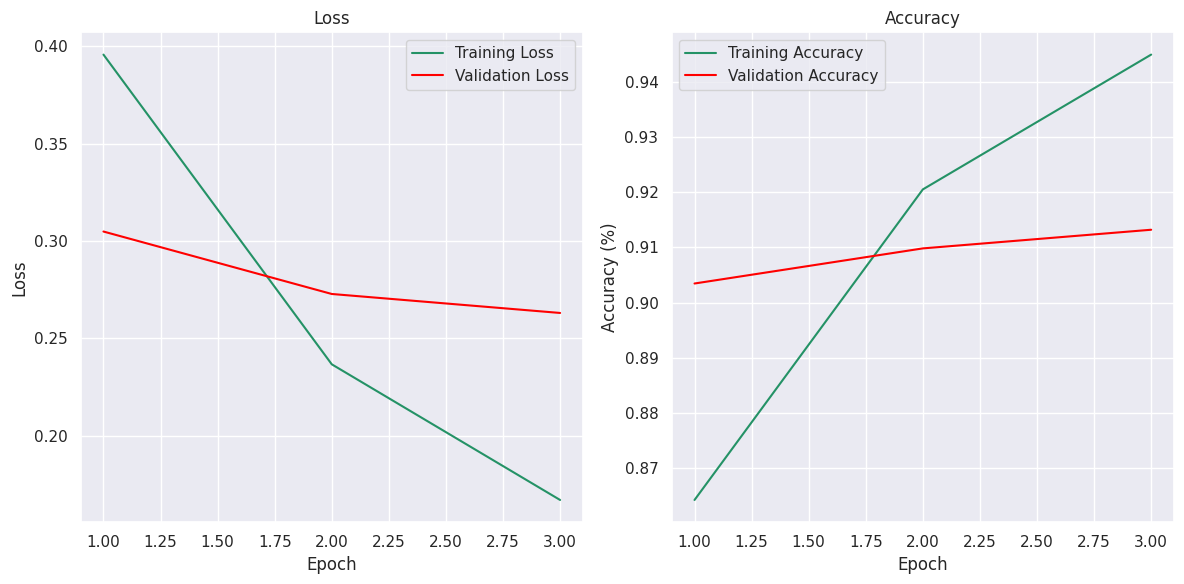

NameError: name 'best_model' is not defined

In [ ]:
CFG.epochs=3
best_model = test_model(GRUModel, bi=True, rnn_layers=3)
evaluate(best_model, eval_dataloader)

#### Tune hyperparameters

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch Train: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.5856
acc: 77.95


Epoch Val: 1:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.4054
acc: 86.11
Epoch: 1/6:
	Train:                                  
		train_loss = 0.58558                                  
		train acc = 0.78%                                  
	Val:                                  
		val loss = 0.40535                                   
		val acc = 0.861%


Epoch Train: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.3421
acc: 88.62


Epoch Val: 2:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3568
acc: 88.28
Epoch: 2/6:
	Train:                                  
		train_loss = 0.34207                                  
		train acc = 0.886%                                  
	Val:                                  
		val loss = 0.35681                                   
		val acc = 0.883%


Epoch Train: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2929
acc: 90.37


Epoch Val: 3:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3268
acc: 89.23
Epoch: 3/6:
	Train:                                  
		train_loss = 0.29287                                  
		train acc = 0.904%                                  
	Val:                                  
		val loss = 0.32683                                   
		val acc = 0.892%


Epoch Train: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2558
acc: 91.61


Epoch Val: 4:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3261
acc: 89.81
Epoch: 4/6:
	Train:                                  
		train_loss = 0.25579                                  
		train acc = 0.916%                                  
	Val:                                  
		val loss = 0.32613                                   
		val acc = 0.898%


Epoch Train: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2276
acc: 92.49


Epoch Val: 5:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3057
acc: 90.29
Epoch: 5/6:
	Train:                                  
		train_loss = 0.22764                                  
		train acc = 0.925%                                  
	Val:                                  
		val loss = 0.30567                                   
		val acc = 0.903%


Epoch Train: 6:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1778
acc: 94.16


Epoch Val: 6:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2937
acc: 91.16
Epoch: 6/6:
	Train:                                  
		train_loss = 0.17785                                  
		train acc = 0.942%                                  
	Val:                                  
		val loss = 0.29369                                   
		val acc = 0.912%


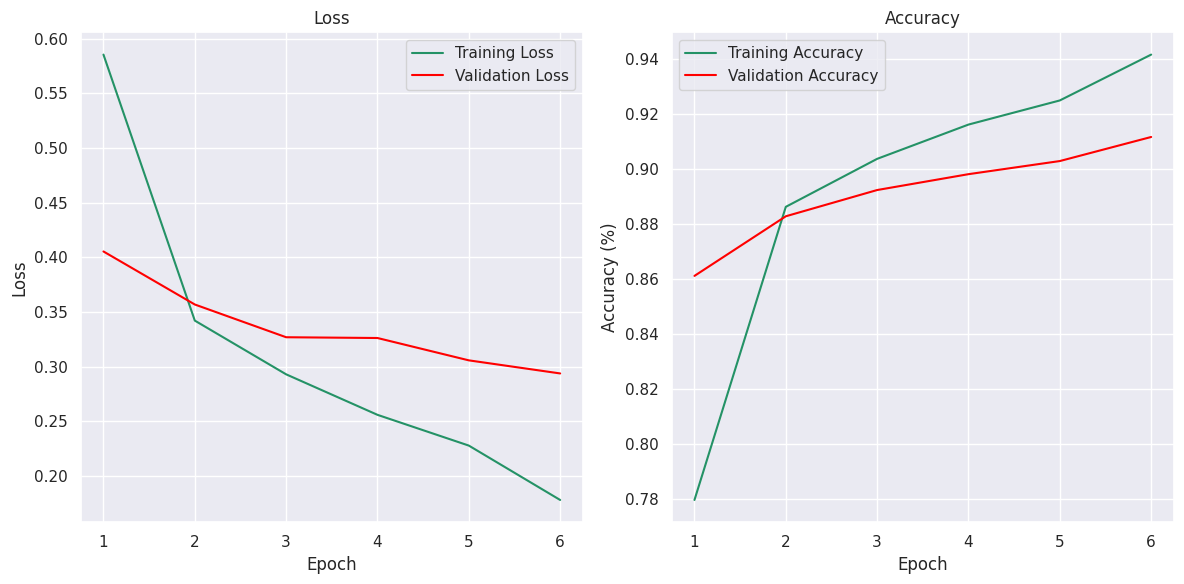

0.9111999869346619

In [ ]:
CFG.epochs = 6
best_model = test_model(RNNModel, hd=1024, rnn_layers = 4, lr=3e-4, bi=True)
evaluate(best_model, eval_dataloader)

### Increase accuracy (3 points)

Well, LSTM could reach the goal from second epoch , so I'd consider this goal to be achieved and task completed.

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch Train: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.3813
acc: 86.57


Epoch Val: 1:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2981
acc: 90.64
Epoch: 1/5:
	Train:                                  
		train_loss = 0.38132                                  
		train acc = 0.866%                                  
	Val:                                  
		val loss = 0.29809                                   
		val acc = 0.906%


Epoch Train: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2221
acc: 92.49


Epoch Val: 2:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2627
acc: 91.34
Epoch: 2/5:
	Train:                                  
		train_loss = 0.22214                                  
		train acc = 0.925%                                  
	Val:                                  
		val loss = 0.26268                                   
		val acc = 0.913%


Epoch Train: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1493
acc: 94.89


Epoch Val: 3:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2762
acc: 91.34
Epoch: 3/5:
	Train:                                  
		train_loss = 0.22214                                  
		train acc = 0.925%                                  
	Val:                                  
		val loss = 0.26268                                   
		val acc = 0.913%


Epoch Train: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.0906
acc: 96.89


Epoch Val: 4:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3245
acc: 91.04
Epoch: 4/5:
	Train:                                  
		train_loss = 0.22214                                  
		train acc = 0.925%                                  
	Val:                                  
		val loss = 0.26268                                   
		val acc = 0.913%


Epoch Train: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.0538
acc: 98.11


Epoch Val: 5:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.4046
acc: 90.88
Epoch: 5/5:
	Train:                                  
		train_loss = 0.22214                                  
		train acc = 0.925%                                  
	Val:                                  
		val loss = 0.26268                                   
		val acc = 0.913%


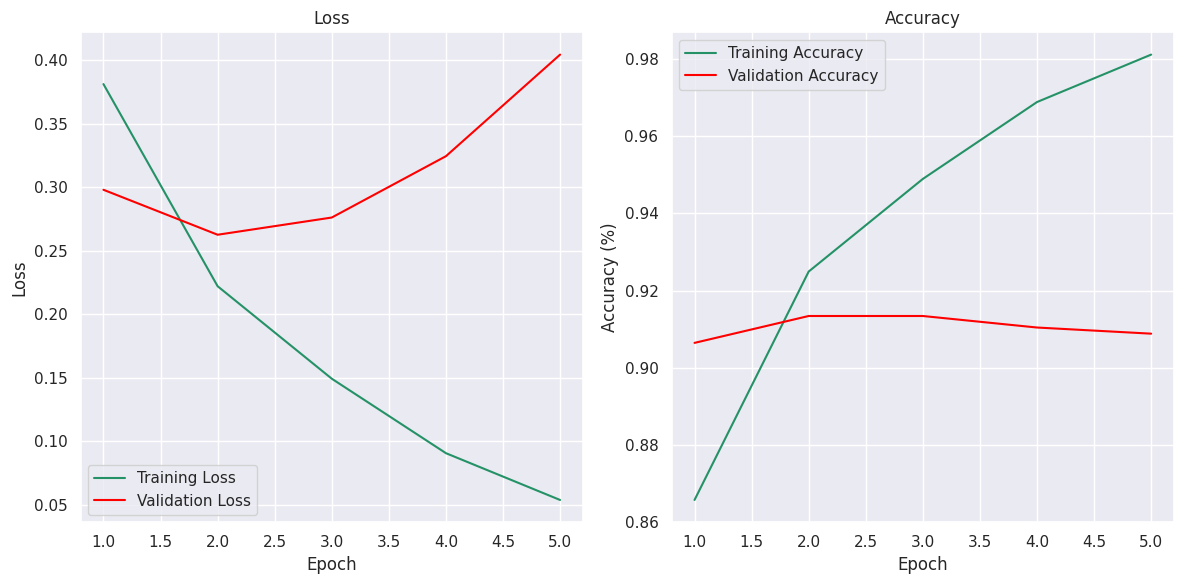

0.9083999991416931

In [ ]:
CFG.epochs = 5
best_model = test_model(LSTMModel, bi=True, rnn_layers=3)
evaluate(best_model, eval_dataloader)

### Write a report (2 points)

1. show what experiments have increased performance
2. Analyze training graphs
3. select optimal model